# Data cleaning and visualization with pandas

This notebook will introduce you to intermediate tasks using the [`pandas`](https://pandas.pydata.org/) data analysis library and demonstrate how to dedupe, clean, group, merge/join and visualize a data set.

The data for this exercise will be a CSV of opioid deaths reported in Minnesota. Many examples here are adapted from work by Mary Jo Webster.

(If you're completely new to Python or your syntax is rusty, it might be useful to [keep this notebook open in a new tab](Python%20syntax%20cheat%20sheet.ipynb) as a reference.)

#### Session outline
- [Import pandas; load a csv into a data frame](#Import-pandas;-load-a-csv-into-a-data-frame)
- [Inspect the data](#Inspect-the-data)
- [Checking for duplicate records](#Checking-for-duplicate-records-with-groupby())
- [Renaming a column](#Renaming-a-column)
- [Recoding data with lambda()](#Recoding-data-with-lambda())
- [Cleaning up inconsistent values](#Cleaning-up-inconsistent-values)
- [Visualize the data with a bar chart](#Visualize-the-data-with-a-bar-chart)
- [Extracting year from a date](#Extracting-year-from-a-date)
- [Merging with other data (Joins)](#Merging-with-other-data)
- [Mapping TK](#Mapping-TK)

### For reference: Using Jupyter notebooks

There are many ways to write and run Python code on your computer. One way -- the method we're using today -- is to use [Jupyter notebooks](https://jupyter.org/), which run in your browser and allow you to intersperse documentation with your code. They're handy for bundling your code with a human-readable explanation of what's happening at each step. Check out some examples from the [L.A. Times](https://github.com/datadesk/notebooks) and [BuzzFeed News](https://github.com/BuzzFeedNews/everything#data-and-analyses).

**To add a new cell to your notebook**: Click the + button in the menu.

**To run a cell of code**: Select the cell and click the "Run" button in the menu, or you can press Shift+Enter.

**One common gotcha**: The notebook doesn't "know" about code you've written until you've _run_ the cell containing it. For example, if you define a variable called `my_name` in one cell, and later, when you try to access that variable in another cell but get an error that says `NameError: name 'my_name' is not defined`, the most likely solution is to run (or re-run) the cell in which you defined `my_name`.

### Import pandas; load a csv into a data frame

This was covered in more detail in the previous session, so we'll keep moving.

In [5]:
import pandas as pd
df = pd.read_csv('data/opiate_deaths.csv')
df

,STATEID,FIRSTNAME,MIDDLENAME,LASTNAME,MAIDENNAME,SUFFIX,BIRTHDATE,DEATHDATE,GENDER,RACE,...,DEATHCOUNTY,MANNERDEATH,INJURY_DATE,INJURYPLACE,INJURYSTATE,INJURYCOUNTY,INJURY_FIPS,INJURYDESC,CAUSEA,CAUSEB
0,2005-MN-006548,LANCE,NaN,CHOMMIE,NaN,NaN,12/16/1953,2/26/2005,M,White,...,ANOKA,ACCIDENT,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,DECEDENT INGESTED AN UNKNOWN AMOUNT OF OXYCODONE,OXYCODONE TOXICITY,NaN
1,2005-MN-009829,CARRIE,ANNE,FISCHER,HOLMES,NaN,6/6/1961,3/27/2005,F,White,...,ANOKA,ACCIDENT,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,DECEDENT INJESTED AN UNKNOWN AMOUNT OF MORPHINE,MORPHINE TOXICITY,NaN
2,2005-MN-023540,ELLIS,RAY,MCGHEE,NaN,NaN,4/4/1963,7/4/2005,M,African American,...,ANOKA,ACCIDENT,NaN,UNSPECIFIED PLACE,UNKNOWN,UNKNOWN,NaN,THE DECEDENT INGESTED AN UNKNOWN AMOUNT OF COC...,MIXED DRUG TOXICITY (COCAINE AND MORPHINE),NaN
3,2005-MN-027612,NATHANIEL,RYE,HAMILTON,NaN,NaN,8/14/1976,9/25/2005,M,White,...,ANOKA,ACCIDENT,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,THE DECEDENT INGESTED AN UNKNOWN AMOUNT OF OXY...,MIXED DRUG TOXICITY (OXYCODONE AND ALPRAZOLAM),NaN
4,2005-MN-028477,JILL,KRISTINA,BROWN,NaN,NaN,4/14/1982,10/3/2005,F,White,...,ANOKA,SUICIDE,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,DEC INGESTED AN UNKNOWN AMOUNT OF SEROQUEL AND...,QUETIAPINE AND OXYCODONE TOXICITY,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3802,2016-MN-029127,STEPHEN,KIRK,PATTERSON,NaN,NaN,3/2/1987,8/31/2016,M,White,...,WRIGHT,ACCIDENT,8/31/2016,PRIVATE RESIDENCE,MINNESOTA,WRIGHT,27171.0,THE DECEDENT SELF-ADMINISTERED HEROIN AND ETHANOL,MIXED HEROIN AND ALCOHOL TOXICITY,NaN
3803,2017-MN-018317,TIMOTHY,ROBERT,WARD,NaN,NaN,4/13/1966,5/26/2017,M,White,...,WRIGHT,ACCIDENT,NaN,PRIVATE RESIDENCE,MINNESOTA,WRIGHT,27171.0,THE DECEDENT SELF-ADMINISTERED EXCESSIVE OXYCO...,OXYCODONE OVERDOSE,NaN
3804,2017-MN-024845,AUSTIN,ADRIAN,HILL,NaN,NaN,12/5/1996,7/23/2017,M,White,...,WRIGHT,ACCIDENT,NaN,PRIVATE RESIDENCE,MINNESOTA,WRIGHT,27171.0,THE DECEDENT USED ILLICIT FENTANYL,FENTANYL TOXICITY,NaN
3805,2014-MN-009504,STEPHANIE,PAIGE,LABATTE,NaN,NaN,1/14/1984,3/23/2014,F,American Indian,...,YELLOW MEDICINE,ACCIDENT,3/23/2014,PROJECT TURNABOUT,MINNESOTA,YELLOW MEDICINE,27173.0,OVERDOSE OF FENTANYL. STEPHANIE LABATTE INGES...,OVERDOSE OF FENTANYL,DEPRESSION


### Inspect the data

Let's quickly check what columns are in our data...

In [2]:
df.columns

Index(['STATEID', 'FIRSTNAME', 'MIDDLENAME', 'LASTNAME', 'MAIDENNAME',
       'SUFFIX', 'BIRTHDATE', 'DEATHDATE', 'GENDER', 'RACE',
       'HISPANICETHNICITY', 'AGEYEARS', 'RESADDRESS', 'RESSTATE', 'RESCITY',
       'RESCOUNTY', 'ZIP', 'ARMEDFORCES', 'YEARSEDUCATION', 'OCCUPATION',
       'INDUSTRY', 'MARITALSTATUS', 'PLACETYPE', 'DEATHCITY', 'DEATHCOUNTY',
       'MANNERDEATH', 'INJURY_DATE', 'INJURYPLACE', 'INJURYSTATE',
       'INJURYCOUNTY', 'INJURY_FIPS', 'INJURYDESC', 'CAUSEA', 'CAUSEB'],
      dtype='object')

... and see how many rows and columns are in the data

In [3]:
df.shape

(3807, 34)

## Cleaning your data

When you receive data, it will almost always need some cleanup to be ready for analysis and/or display. There are some common issues to look for when you have acquired a new dataset.

- Duplicate records
- Misspellings
- Inconsistent category/variable names
- Null or empty (`''`) values that may affect calculations

### Checking for duplicate records with groupby()

Each record has a `STATEID`, which seems to imply that each row represents a unique death. But how do we know? We can use the `groupby()` method to count how many times each `STATEID` value appears. If each row is a unique person or case, there should be only 1 copy of each value.

In pandas we can chain several methods together to achieve our desired output.

Here's the full command (we'll break down the details next):

In [4]:
df[['STATEID', 'DEATHCITY']].groupby('STATEID').count().reset_index().sort_values('DEATHCITY', ascending=False)

,STATEID,DEATHCITY
0,2005-MN-000344,1
2543,2014-MN-037772,1
2531,2014-MN-035649,1
2532,2014-MN-035971,1
2533,2014-MN-036080,1
...,...,...
1273,2010-MN-035079,1
1274,2010-MN-035176,1
1275,2010-MN-035257,1
1276,2010-MN-035518,1


### Groupby, one piece at a time

First, let's run our groupby on a subset of the data:

`df[['STATEID', 'DEATHCITY']]`

This will return a view of the dataframe that only includes the STATEID and DEATHCITY columns.

Why do we even need `DEATHCITY` in this case? Because `groupby()` calls need at least two fields to work right. One or more fields that we are grouping on (`STATEID` in this case), and another field to be counted.

`df[['STATEID', 'DEATHCITY']].groupby('STATEID')`

And we'll add a `count()` call to tell pandas that we want to count the number of rows in each group, as opposed to other methods like summing or finding the average of that group.

`df[['STATEID', 'DEATHCITY']].groupby('STATEID').count()`

Next we need to include a weird pandas thing, `reset_index()` This is because otherwise, when performing a groupby, pandas will produce a MultiIndex, which is more complex than we need.

`df[['STATEID', 'DEATHCITY']].groupby('STATEID').count().reset_index()`

And finally we'll sort the results by our counted column, `DEATHCITY`. We want to surface any non-unique `STATEID`s, so we'll sort in descending order.

`df[['STATEID', 'DEATHCITY']].groupby('STATEID').count().reset_index().sort_values('DEATHCITY', ascending=False)`

Great news, the highest count is 1, meaning there are no `STATEID`s that occur more than once.

### ✍️ Your turn

Let's find out how many deaths occured in each city. Take the next few minutes to see if you can group the datafame by the `DEATHCITY` column and count the number of rows from each city.

Here's a start for you to build on:

In [6]:
deaths_by_city = df[['DEATHCITY', 'STATEID']]  # Your code herey...

In [6]:
# Remove before class
deaths_by_city = df[['DEATHCITY', 'STATEID']].groupby('DEATHCITY').count().reset_index().sort_values('STATEID', ascending=False)
deaths_by_city

,DEATHCITY,STATEID
241,MINNEAPOLIS,829
341,SAINT PAUL,285
98,DULUTH,138
337,SAINT CLOUD,93
325,ROCHESTER,89
...,...,...
249,MOOSE LAKE,1
251,MORRILL TOWNSHIP,1
253,MORRISTOWN,1
254,MORTON,1


### Renaming a column

It's confusing that the count of cities is held in a column called `STATEID`, which doesn't really have any meaning. It's always a good idea to have column headers that you can clearly understand, so let's rename the `STATEID` column in our `groupby()` to `death_count`. Note that this does NOT change the `STATEID` column in the original dataframe, as we are now working on a copy of a subset of that original data.

In [7]:
deaths_by_city.rename(columns={'STATEID': 'death_count'}, inplace=True)
deaths_by_city

/Users/akanik/.virtualenvs/teaching-guide-data-cleaning-and-viz-with--Yo5GS_kn/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,DEATHCITY,death_count
0,COON RAPIDS,2005-MN-006548
1,COLUMBIA HEIGHTS,2005-MN-009829
2,COLUMBIA HEIGHTS,2005-MN-023540
3,COON RAPIDS,2005-MN-027612
4,BLAINE,2005-MN-028477
...,...,...
3802,MONTROSE,2016-MN-029127
3803,DELANO,2017-MN-018317
3804,ROCKFORD TOWNSHIP,2017-MN-024845
3805,GRANITE FALLS,2014-MN-009504


**A note on `inplace=True`:** 

Most functions that you run on your dataframes need to be assigned to variables in order to be accessed at a later time. For example, if we were to write...

`df['DEATHCITY'].drop_duplicates()`

... to get a listing of unique cities in which people died, that would not affect our dataframe `df`. If we wanted it to store that new data somewhere to access later, we would would have to write:

`unique_cities = df['DEATHCITY'].drop_duplicates()`

We could also add `inplace=True`  the function without assigning it to a variable and the dataframe will be changed:

`df['DEATHCITY'].drop_duplicates(inplace=True)`

### Recoding data with lambda()

We can also use pandas to change the data values to something more presentable or consistent. For example, let's look at the unique values for the `GENDER` column:

In [8]:
df.GENDER.unique()

array(['M', 'F'], dtype=object)

Let's change all the values in `GENDER` to the slightly more user-friendly `Male` and `Female`. We'll use a lambda function. A lambda function is shorthand way of writing what you would like to do to each row of data in this column. It's usually safer to add a new column than to change the underlying data, so we'll create a new column called `gender_clean`, and populate it with values from the `GENDER` column that we have run through our little lambda factory.

In [9]:
df['gender_clean'] = df['GENDER'].apply(lambda x: 'Male' if x == 'M' else 'Female')
df['gender_clean']

0         Male
1       Female
2         Male
3         Male
4       Female
         ...  
3802      Male
3803      Male
3804      Male
3805    Female
3806    Female
Name: gender_clean, Length: 3807, dtype: object

In this case, each row was either labeled M or F, but our basic `if this, else that` logic is too naive for most real-world situations. For example, what if some rows had a value of `NA` or were null? In the above function, those rows would have gotten erroneously marked as `Female`. That's correction waiting to happen.

### A slightly more complex `lambda()`

To introduce more complex logic, we'll still use a lambda(). But instead of cramming the logic of what we want to do into one line, we'll use the lambda to apply an external function to each row.

Here's the function we'll apply to each row:

In [10]:
def decode_gender(input):
    if input == 'M':
        return 'Male'
    elif input == 'F':
        return 'Female'
    else:
        return None

We may not have thought of every possible exception, but at least we won't wrongly assign some values to either male or female.

Now let's apply the `decode_gender` function to each row's `GENDER` column using lambda.

In [11]:
df['gender_clean'] = df['GENDER'].apply(lambda x: decode_gender(x))
df['gender_clean'].drop_duplicates()

0      Male
1    Female
Name: gender_clean, dtype: object

### Cleaning up inconsistent values

Now let's take a look at the values in the `HISPANICETHNICITY` column:

In [12]:
df.HISPANICETHNICITY.unique()

array(['NOT HISPANIC', 'HISPANIC', 'UNKNOWN', 'non-hispanic', 'hispanic',
       'NON-HISPANIC', 'not hispanic', 'NOT-HISPANIC'], dtype=object)

Whoa, kind of a mess! We can't easily groupby these values right now because of the inconsistent capitalization and spelling.

One way to harmonize data in a column is to set all of the letters to uppercase. We'll start a new `hispanic_clean` column to avoid introducing errors into our original `HISPANICETHNICITY` column.

In [12]:
df['hispanic_clean'] = df['HISPANICETHNICITY'].str.upper()
df['hispanic_clean'].unique()

array(['NOT HISPANIC', 'HISPANIC', 'UNKNOWN', 'NON-HISPANIC',
       'NOT-HISPANIC'], dtype=object)

OK, we cut our 8 unique values down to 5. But we still have inconsistencies in the spelling and hyphenation.

Let's deal with the simple hyphens first, by searching for and replacing instances of `NON HISPANIC`, sans hyphen. You'll notice that now we're modifying `hispanic_clean`, which we just created, directly. If we ran this against the original `HISPANICETHNICITY` column, we'd mess up some of our previous work on `hispanic_clean`.

Like most search and replace functions, the arguments passed to `replace()` are writtin the order of `1. Needle` in the `2. Haystack` you are searching through.

In [13]:
df['hispanic_clean'] = df['hispanic_clean'].str.replace('NON HISPANIC', 'NON-HISPANIC')
df['hispanic_clean'].unique()

array(['NOT HISPANIC', 'HISPANIC', 'UNKNOWN', 'NON-HISPANIC',
       'NOT-HISPANIC'], dtype=object)

Better again! Now let's tackle the `NOT HISPANIC` rows, some of which have a hyphen and some that don't. We could write two lines that are similar to what we just did, but let's throw in a regular expression that can account for cases both with and without the hyphen.

`.replace(r'NOT(-| )HISPANIC', 'NON-HISPANIC')`

The `r` preceding the string tells python this is a regular expression, not a normal string.

The `(-| )` means that either a hypen or a space is an acceptable value to call a match. In either case, the command will write `NON-HISPANIC` instead.

In [14]:
df['hispanic_clean'] = df['hispanic_clean'].str.replace(r'NOT(-| )HISPANIC', 'NON-HISPANIC')
df['hispanic_clean'].unique()

array(['NON-HISPANIC', 'HISPANIC', 'UNKNOWN'], dtype=object)

What a tidy column we have now!

### ✍️ Your turn

In the cell below, group by and count the `df` data frame:
- Get a subset of the `df` data frame
- Group by `hispanic_clean`
- Count the rows with each value
- Order descending
- Rename the count to a new variable called `death_count` after grouping

In [16]:
# deaths_by_hispanic_ethnicity = 

In [15]:
# Remove before class
deaths_by_hispanic_ethnicity = df[['hispanic_clean', 'STATEID']].groupby('hispanic_clean').count().reset_index().sort_values('STATEID', ascending=False)
deaths_by_hispanic_ethnicity.rename(columns={'STATEID': 'death_count'}, inplace=True)
deaths_by_hispanic_ethnicity

,hispanic_clean,death_count
1,NON-HISPANIC,3725
0,HISPANIC,76
2,UNKNOWN,6


In our data, the vast majority of deaths are from people without Hispanic ethnicity. But Minnesota is a pretty white state, so we need to look at these numbers as a percentage, so we can compare the deaths to Minnesota's overall Hispanic population, which is about 5% of the state's total population, according to Pew Research.

We can create a new column to calculate the percentage:

In [16]:
deaths_by_hispanic_ethnicity['pct_total'] = deaths_by_hispanic_ethnicity['death_count'] / deaths_by_hispanic_ethnicity['death_count'].sum()
deaths_by_hispanic_ethnicity

,hispanic_clean,death_count,pct_total
1,NON-HISPANIC,3725,0.978461
0,HISPANIC,76,0.019963
2,UNKNOWN,6,0.001576


### Visualize the data with a bar chart

Pandas works well with a visualization package called [`matplotlib`](https://matplotlib.org/). There are several other visualization packages that have robust feature sets, including [Altair](https://altair-viz.github.io/), but matplotlib is already tightly integrated with pandas, so we'll start with that.

It doesn't make for the most compelling chart in the world, but once you have your data cleaned up, it's easy to make a simple bar chart:

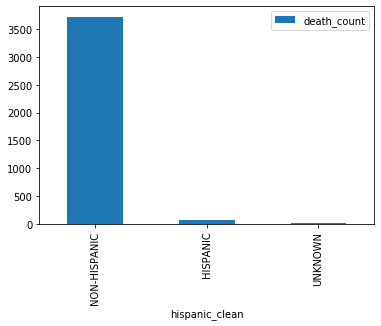

In [17]:
deaths_by_hispanic_ethnicity.plot.bar(x='hispanic_clean', y='death_count')

### Extracting year from a date

To look at the trend in deaths over time, we can grab just the year from the `DEATHDATE` column by taking advantage of Python's date-handling abilities. First we need to tell pandas that the `DEATHDATE` column is a `datetime`, not just an ordinary string.

In [18]:
df['DEATHDATE'] = pd.to_datetime(df['DEATHDATE'])

Now we can use `lambda` to call `.year` on each `DEATHDATE`, and pipe it to a new column.

In [19]:
df['death_year'] = df['DEATHDATE'].apply(lambda x: x.year)
df['death_year']

0       2005
1       2005
2       2005
3       2005
4       2005
        ... 
3802    2016
3803    2017
3804    2017
3805    2014
3806    2014
Name: death_year, Length: 3807, dtype: int64

### ✍️ Your turn

In the cells below, group by and count the `df` data frame:
- Get a subset of the `df` data frame
- Group by `death_year`
- Count the rows with each value
- Order by death year
- Rename the count to a new variable called `death_count` after grouping
- Plot the death years on a bar chart

In [22]:
# deaths_by_year =

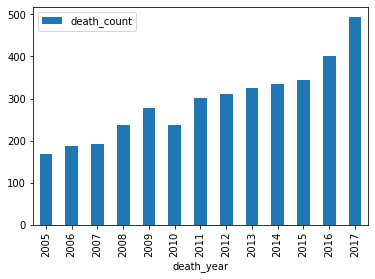

In [20]:
# Remove before class
deaths_by_year = df[['death_year', 'STATEID']].groupby('death_year').count().reset_index().sort_values('death_year')
deaths_by_year.rename(columns={'STATEID': 'death_count'}, inplace=True)
deaths_by_year.plot.bar(x='death_year', y='death_count')

### Merging with other data

If you remember our city `deaths_by_city` data from above, it's not surprising that Minnesota's largest city has the highest raw death count -- there are so many more people. The data would be a lot more meaningful if we could calculate the deaths per capita. But population isn't in our original CSV. But we can join our data with other data sources, provided they have some kind of identical value to join on.

First, we load a spreadsheet of population data from a reliable source from a similar time period.

In [21]:
pop_estimates = pd.read_csv('data/mn_cities_pop_estimates.csv')
pop_estimates

,FIPS10,County Name,City Name,"Total Population, 2018","Population in Households, 2018","Population in Group Quarters, 2018","Households, 2018","Persons per Household, 2018"
0,2700100460,Aitkin,Aitkin,2123,1919,204,937,2.05
1,2700129096,Aitkin,Hill City,622,611,11,271,2.25
2,2700138996,Aitkin,McGrath,73,62,11,31,2.00
3,2700139014,Aitkin,McGregor,381,381,-,179,2.13
4,2700149498,Aitkin,Palisade,152,152,-,69,2.20
...,...,...,...,...,...,...,...,...
849,2799961996,Multi-County City,Spring Lake Park,6410,6394,16,2698,2.37
850,2799962446,Multi-County City,Staples,2972,2754,218,1256,2.19
851,2799963778,Multi-County City,Swanville,348,348,-,143,2.43
852,2799967504,Multi-County City,Wadena,4150,3987,163,1891,2.11


Uh oh, the cities in this data set are Title Case, and the cities in our opiates data are ALL UPPERCASE.

Let's make the population csv's city names all uppercase as well:

In [22]:
pop_estimates['city_name_capped'] = pop_estimates['City Name'].str.upper()

In [23]:
deaths_by_city_merged = deaths_by_city.merge(
    pop_estimates,
    how="left",
    left_on="DEATHCITY",
    right_on="city_name_capped"
)
deaths_by_city_merged

,DEATHCITY,death_count,FIPS10,County Name,City Name,"Total Population, 2018","Population in Households, 2018","Population in Group Quarters, 2018","Households, 2018","Persons per Household, 2018",city_name_capped
0,COON RAPIDS,2005-MN-006548,2.700313e+09,Anoka,Coon Rapids,63899.0,63497.0,402,24348.0,2.61,COON RAPIDS
1,COLUMBIA HEIGHTS,2005-MN-009829,2.700313e+09,Anoka,Columbia Heights,20840.0,20628.0,212,8385.0,2.46,COLUMBIA HEIGHTS
2,COLUMBIA HEIGHTS,2005-MN-023540,2.700313e+09,Anoka,Columbia Heights,20840.0,20628.0,212,8385.0,2.46,COLUMBIA HEIGHTS
3,COON RAPIDS,2005-MN-027612,2.700313e+09,Anoka,Coon Rapids,63899.0,63497.0,402,24348.0,2.61,COON RAPIDS
4,BLAINE,2005-MN-028477,2.799906e+09,Multi-County City,Blaine,66667.0,66419.0,248,24206.0,2.74,BLAINE
...,...,...,...,...,...,...,...,...,...,...,...
3808,MONTROSE,2016-MN-029127,2.717144e+09,Wright,Montrose,3247.0,3247.0,-,1183.0,2.74,MONTROSE
3809,DELANO,2017-MN-018317,2.717115e+09,Wright,Delano,6187.0,6129.0,58,2218.0,2.76,DELANO
3810,ROCKFORD TOWNSHIP,2017-MN-024845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3811,GRANITE FALLS,2014-MN-009504,2.799925e+09,Multi-County City,Granite Falls,2762.0,2638.0,124,1260.0,2.09,GRANITE FALLS


### ✍️ Your turn

In the cells below:
- Create a `deaths_per_capita` field for each city by dividing `death_count` by `Total Population, 2018`
- Order the data frame by `deaths_per_capita`
- Plot the per capita deaths on a bar chart

In [26]:
# deaths_by_city_merged['deaths_per_capita'] = 

In [42]:
# Remove before class
deaths_by_city_merged['deaths_per_capita'] = deaths_by_city_merged['death_count'] / deaths_by_city_merged['Total Population, 2018']
deaths_by_city_merged.sort_values('deaths_per_capita', ascending=False, inplace=True)
deaths_by_city_merged['deaths_per_capita']

135    0.044444
321    0.037037
311    0.025000
36     0.022093
93     0.018373
         ...   
392         NaN
393         NaN
399         NaN
405         NaN
413         NaN
Name: deaths_per_capita, Length: 417, dtype: float64

Whoa, that is just too many cities, and when we're doing per capita we need to be cautious about small denominators. Let's restrict the chart to only cities with 30 or more deaths.

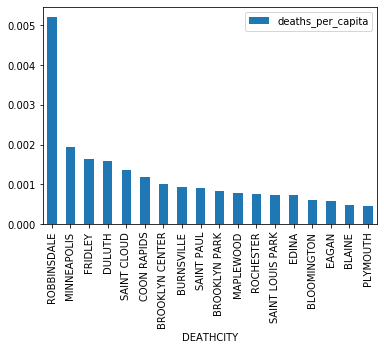

In [43]:
deaths_by_city_30plus = deaths_by_city_merged[deaths_by_city_merged['death_count'] > 30]
deaths_by_city_30plus.plot.bar(x='DEATHCITY', y='deaths_per_capita')

# Mapping

It's great to see these death rates on a bar chart, but a map would help us visualize this geographic dataset in another way.

First, there are a few additional libraries we need to bring in to make this all work.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify
import numpy as np
import os

Instead of city, we're going to work with counties. 

Now we want to bring in our shapefile of Minnesota counties. A shapefile is a mapping file. In this case, the Minnesota counties shapefile defines the boundary lines between different counties in the state of Minnesota. You can find your [shapefiles for your state here](https://www.census.gov/cgi-bin/geo/shapefiles/index.php).

In [24]:
mn_cnty = gpd.read_file('gis/tl_2015_mn_county/tl_2015_mn_county.shp')

Now this looks different than how we've brought data in before. That's because plain jane pandas can't read these types of files. We need to use an additional library called geopandas.

But once you import it you can query it like any other dataframe.

In [25]:
mn_cnty.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,27,095,00659493,27095,Mille Lacs,Mille Lacs County,06,H1,G4020,378,33460,None,A,1482278368,283009546,+45.9290434,-093.6329964,"POLYGON ((-93.76837 45.90970, -93.76860 45.910..."
1,27,045,00659468,27045,Fillmore,Fillmore County,06,H1,G4020,462,40340,None,A,2230757060,2045272,+43.6791876,-092.0939452,"POLYGON ((-91.96985 43.84708, -91.96975 43.847..."
2,27,073,00659482,27073,Lac qui Parle,Lac qui Parle County,06,H1,G4020,None,None,None,A,1981394508,33643131,+44.9998550,-096.1768363,"POLYGON ((-96.45202 44.97947, -96.45203 44.990..."
3,27,085,00659491,27085,McLeod,McLeod County,06,H1,G4020,378,26780,None,A,1272903790,36406719,+44.8216437,-094.2723203,"POLYGON ((-94.49773 44.89233, -94.50000 44.892..."
4,27,153,00659521,27153,Todd,Todd County,06,H1,G4020,None,None,None,A,2447582000,89311191,+46.0665694,-094.9005758,"POLYGON ((-95.14634 46.19407, -95.14634 46.194..."


Now we need to join this shapefile with our death data so we can start to visualize where these deaths are happeneing. In order to do that, we need to find a common column to merge on.

In [31]:
mn_cnty.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

In [30]:
df.columns

Index(['STATEID', 'FIRSTNAME', 'MIDDLENAME', 'LASTNAME', 'MAIDENNAME',
       'SUFFIX', 'BIRTHDATE', 'DEATHDATE', 'GENDER', 'RACE',
       'HISPANICETHNICITY', 'AGEYEARS', 'RESADDRESS', 'RESSTATE', 'RESCITY',
       'RESCOUNTY', 'ZIP', 'ARMEDFORCES', 'YEARSEDUCATION', 'OCCUPATION',
       'INDUSTRY', 'MARITALSTATUS', 'PLACETYPE', 'DEATHCITY', 'DEATHCOUNTY',
       'MANNERDEATH', 'INJURY_DATE', 'INJURYPLACE', 'INJURYSTATE',
       'INJURYCOUNTY', 'INJURY_FIPS', 'INJURYDESC', 'CAUSEA', 'CAUSEB',
       'gender_clean', 'hispanic_clean', 'death_year'],
      dtype='object')

I know (because I added it myself) that the `GEOID` column from my `mn_cnty` shapefile is the same as the `INJURY_FIPS` column from my `df` data file. So, in order to merge these two together, I'm going to have to group by deaths data by county.

In [44]:
deaths_by_cnty = df[['INJURY_FIPS', 'STATEID']].groupby('INJURY_FIPS').count().reset_index().sort_values('STATEID', ascending=False)
deaths_by_cnty['INJURY_FIPS'] = deaths_by_cnty['INJURY_FIPS'].astype(int).astype(str)

That second line converts the data type of our `INJURY_FIPS` field to a string. This is important because the `GEOID` field in our shapefile is stored as a string and we cannot merge two dataframes together on columns with mismatched data types.

I know that might sound like I'm speaking a different language but just tuck that knowledge away somewhere and some day you'll get an error message `ValueError: You are trying to merge on object and float64 columns.` and you'll be like... What did that woman tell me about merging on mismatched data types...

In [53]:
deaths_by_cnty_merged = mn_cnty.merge(
    deaths_by_cnty,
    how="left",
    left_on="GEOID",
    right_on="INJURY_FIPS"
)
deaths_by_cnty_merged

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,INJURY_FIPS,STATEID
0,27,095,00659493,27095,Mille Lacs,Mille Lacs County,06,H1,G4020,378,33460,None,A,1482278368,283009546,+45.9290434,-093.6329964,"POLYGON ((-93.76837 45.90970, -93.76860 45.910...",27095,23.0
1,27,045,00659468,27045,Fillmore,Fillmore County,06,H1,G4020,462,40340,None,A,2230757060,2045272,+43.6791876,-092.0939452,"POLYGON ((-91.96985 43.84708, -91.96975 43.847...",27045,3.0
2,27,073,00659482,27073,Lac qui Parle,Lac qui Parle County,06,H1,G4020,None,None,None,A,1981394508,33643131,+44.9998550,-096.1768363,"POLYGON ((-96.45202 44.97947, -96.45203 44.990...",27073,1.0
3,27,085,00659491,27085,McLeod,McLeod County,06,H1,G4020,378,26780,None,A,1272903790,36406719,+44.8216437,-094.2723203,"POLYGON ((-94.49773 44.89233, -94.50000 44.892...",27085,8.0
4,27,153,00659521,27153,Todd,Todd County,06,H1,G4020,None,None,None,A,2447582000,89311191,+46.0665694,-094.9005758,"POLYGON ((-95.14634 46.19407, -95.14634 46.194...",27153,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,27,119,00659505,27119,Polk,Polk County,06,H1,G4020,None,24220,None,A,5105112392,69128487,+47.7742536,-096.4000265,"POLYGON ((-97.07218 48.02064, -97.07191 48.021...",27119,23.0
83,27,127,00659509,27127,Redwood,Redwood County,06,H1,G4020,None,None,None,A,2275491166,8230304,+44.4035357,-095.2542415,"POLYGON ((-95.36040 44.54176, -95.36041 44.542...",27127,6.0
84,27,055,00659473,27055,Houston,Houston County,06,H1,G4020,None,29100,None,A,1429818691,43461981,+43.6669899,-091.5015556,"POLYGON ((-91.31497 43.84707, -91.31385 43.847...",27055,4.0
85,27,019,00659455,27019,Carver,Carver County,06,H1,G4020,378,33460,None,A,917699930,56427530,+44.8213196,-093.8000913,"POLYGON ((-94.01002 44.80210, -94.01002 44.803...",27019,26.0


Ok look at that! Merged!

Now we have to clean up our data just a touch before we can map this puppy.

First, we're going to rename that `STATEID` column because, again, it's actually our death counts column.

In [54]:
deaths_by_cnty_merged.rename(columns={'STATEID': 'death_count'}, inplace=True)

Next we're going to replace all of the `NA` values in that death_counts column with 0 values. Because we joined the death data INTO the shapefile, it is possible that we will have counties without deaths.

And that is the case. We have 87 counties in Minnesota:

In [51]:
len(mn_cnty)

87

And only 77 of those counties have death data:

In [50]:
len(deaths_by_cnty)

77

Let's visualize the change. Here are all the values found in the `death_count` field in our merged dataframe:

In [56]:
deaths_by_cnty_merged['death_count'].values

array([ 23.,   3.,   1.,   8.,   9.,   2.,  21.,   4.,   1.,   5.,  11.,
         2.,   3.,  51.,   4.,   3.,   3.,  nan,   4.,  nan,  33.,  32.,
        33.,   7.,  nan,  21.,   1.,  25.,  19.,   3.,  16.,  25.,   7.,
         7.,   1.,  nan,  14.,  24., 177.,  nan, 170.,  18.,   2., 329.,
        nan,  13.,  20.,   3.,   3.,   7.,  74.,  21.,  nan,   2.,  18.,
        56.,  30.,   4.,   4.,   4.,  nan,   3.,   1.,  28.,  14.,   3.,
         2.,   2.,  16.,  nan,   2.,  11., 550.,  nan,   4.,   5.,   1.,
         9.,   1.,   1.,   1.,  17.,  23.,   6.,   4.,  26.,   2.])

Now let's run our `fillna` function and look again:

In [57]:
deaths_by_cnty_merged.fillna(value={'death_count': 0}, inplace=True)

In [58]:
deaths_by_cnty_merged['death_count'].values

array([ 23.,   3.,   1.,   8.,   9.,   2.,  21.,   4.,   1.,   5.,  11.,
         2.,   3.,  51.,   4.,   3.,   3.,   0.,   4.,   0.,  33.,  32.,
        33.,   7.,   0.,  21.,   1.,  25.,  19.,   3.,  16.,  25.,   7.,
         7.,   1.,   0.,  14.,  24., 177.,   0., 170.,  18.,   2., 329.,
         0.,  13.,  20.,   3.,   3.,   7.,  74.,  21.,   0.,   2.,  18.,
        56.,  30.,   4.,   4.,   4.,   0.,   3.,   1.,  28.,  14.,   3.,
         2.,   2.,  16.,   0.,   2.,  11., 550.,   0.,   4.,   5.,   1.,
         9.,   1.,   1.,   1.,  17.,  23.,   6.,   4.,  26.,   2.])

Look! No more `nan` values! This will allow us to visualize counties with 0 deaths on the map. If we left those as `nan` valuse, the map would omit the county all together and we'd have a swiss cheese map on our hands.

/Users/akanik/.virtualenvs/teaching-guide-data-cleaning-and-viz-with--Yo5GS_kn/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


JenksCaspall            

    Interval       Count
------------------------
[  0.00,   1.00] |    19
(  1.00,   8.00] |    33
(  8.00,  19.00] |    13
( 19.00,  74.00] |    18
( 74.00, 550.00] |     4


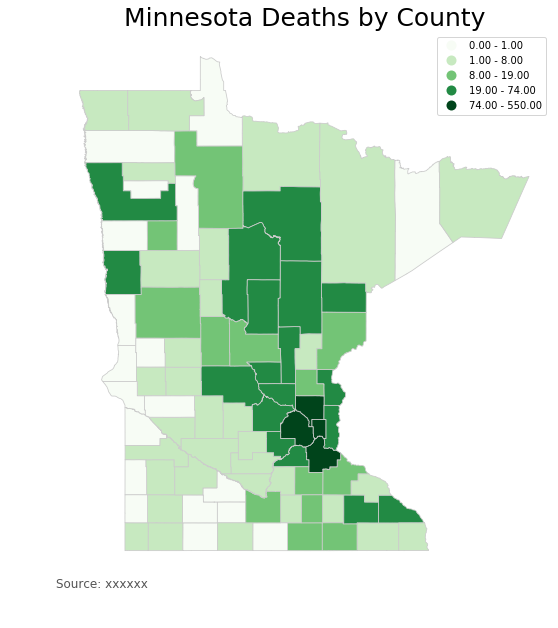

In [60]:
#fix our map projection so it looks prettier
deaths_by_cnty_merged = deaths_by_cnty_merged.to_crs('EPSG:3395')

vmin = deaths_by_cnty_merged.death_count.min()
vmax = deaths_by_cnty_merged.death_count.max()
fig, ax = plt.subplots(1, figsize=(10, 10))

# we don't need axes for a map
ax.axis('off')

# add a title
ax.set_title('Minnesota Deaths by County', fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: xxxxxx', xy=(0.1, .08),  xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

#This bit tells us how many counties are in each bucket
print(mapclassify.JenksCaspall(deaths_by_cnty_merged.death_count, k=5))

#This bit actually builds the map
deaths_by_cnty_merged.plot(column='death_count', cmap='Greens', linewidth=0.8, ax=ax, 
                           edgecolor='0.8', scheme='JenksCaspall', legend=True)

# If we need another example but this is too much already

### Grouping values into new categories

For a more informative bar chart, let's tag each row with a new `age_group` value. We can use `lambda()` and `apply()`, as we did above.

First, our function:

In [ ]:
def get_age_group(age):
    if age < 20:
        return '0-19'
    elif age >=20 and age < 35:
        return '20-34'
    elif age >= 35 and age < 50:
        return '35-49'
    elif age >= 50 and age < 70:
        return '50-69'
    elif age >= 70:
        return '70 and over'
    return 'Unknown'    

And now let's apply it to each row's `AGEYEARS` column

In [ ]:
df['age_group'] = df.AGEYEARS.apply(lambda x: get_age_group(x))

And be sure to check that the results make sense...

In [ ]:
df[['age_group', 'AGEYEARS']]

### ✍️ Your turn

In the cells below, group by and count the `df` data frame:
- Get a subset of the `df` data frame
- Group by `age_group`
- Count the rows with each value
- Order by age group
- Rename the count to a new variable called `death_count` after grouping
- Plot the age groups on a bar chart